In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
new_account_df = pd.read_csv('new_account.csv')
new_contact_df = pd.read_csv('new_contact.csv')
new_pmdm_df = pd.read_csv('new_pmdm.csv')
new_client_goal_df = pd.read_csv('new_client_goal.csv')
new_case_note_df = pd.read_csv('new_case_note.csv')
new_income_df = pd.read_csv('new_income.csv')
new_wage_detail_df = pd.read_csv('new_wage_detail.csv')
new_assessment_df = pd.read_csv('new_assessment.csv')
new_education_history_df = pd.read_csv('new_education_history.csv')
new_employment_history_df = pd.read_csv('new_employment_history.csv')
new_pmdm_servicedelivery_df = pd.read_csv('new_pmdm_servicedelivery.csv')
new_partner_agency_enrollment_df = pd.read_csv('new_partner_agency_enrollment.csv')
new_grant_df = pd.read_csv('new_grant.csv')
new_grant_item_df = pd.read_csv('new_grant_item.csv')
new_financial_assistance_df = pd.read_csv('new_financial_assistance.csv')

dfs = [new_account_df, new_contact_df, new_pmdm_df, new_case_note_df, new_income_df, new_wage_detail_df, new_assessment_df, new_education_history_df, new_employment_history_df, new_pmdm_servicedelivery_df, new_partner_agency_enrollment_df, new_client_goal_df, new_grant_df, new_grant_item_df, new_financial_assistance_df]

/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_28342/773357567.py:5: DtypeWarning: Columns (1,4,5,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,33,35,37,39,40,42,44,46,48,50,52,54,56,57,59,61,62,63,65,66,67,68,70,72,74,76,78,80,81,83,85,86,88,90,91,92,93,95,96,97,98,100,101,103,105,107,109,111,113,115,117,119,121,122,124,126,128,129,131,132,133,134,136,137,138,139,140,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  new_case_note_df = pd.read_csv('/Users/yejinchoi/Desktop/capstone/new_case_note.csv')
/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_28342/773357567.py:11: DtypeWarning: Columns (26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  new_pmdm_servicedelivery_df = pd.read_csv('/Users/yejinchoi/Desktop/capstone/new_pmdm_servicedelivery.csv')


### Goal: Identify which sequences of services (service paths) lead to the best outcomes for families with similar characteristics.

### Step 1: Define “Similar Situations”

In [34]:
# Add ETHNICITY__C and RACE__C to assessment data
new_assessment_df = new_assessment_df.merge(
    new_contact_df[['EXT_ACCOUNTID__C', 'ETHNICITY__C', 'RACE__C']],
    left_on='EXT_PROGRAM_ENGAGEMENT__C',
    right_on='EXT_ACCOUNTID__C',
    how='left'
)

# Count how many participant enrollments exist per family
participant_counts = (
    new_pmdm_df[new_pmdm_df['RECORD_TYPE_NAME__C'] == 'Family_Collective_Participant_Enrollment']
    .groupby('EX_FAMILY_COLLECTIVE_ENROLLMENT__C')
    .size()
    .reset_index(name='num_family_members')
)

# Get Family_Collective_Enrollment rows and attach family size
family_enrollments = new_pmdm_df[new_pmdm_df['RECORD_TYPE_NAME__C'] == 'Family_Collective_Enrollment']
family_enrollments = family_enrollments.merge(
    participant_counts,
    left_on='EXTERNAL_ID__C',
    right_on='EX_FAMILY_COLLECTIVE_ENROLLMENT__C',
    how='left'
)

# Merge num_family_members into assessment data
new_assessment_df = new_assessment_df.merge(
    family_enrollments[['EXTERNAL_ID__C', 'num_family_members']],
    left_on='EXT_PROGRAM_ENGAGEMENT__C',
    right_on='EXTERNAL_ID__C',
    how='left'
)

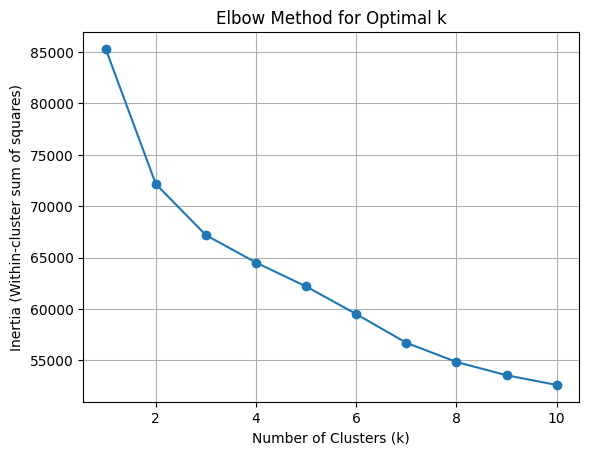

    situation_cluster  ADULT_EDUCATION_ASSM__C  CHILD_CARE_ASSM__C  \
0                   6                        5                   0   
1                   5                        4                   0   
2                   5                        4                   0   
10                  6                        3                   3   
11                  5                        3                   0   

    CHILDRENS_EDUCATION_ASSM__C  COMMUNITY_INVOLVEMENT_ASSM__C  \
0                             5                              3   
1                             5                              3   
2                             5                              3   
10                            5                              4   
11                            5                              2   

    DISABILITIES_ASSM__C  EMPLOYMENT_ASSM__C  FAMILY_SOCIAL_ASSM__C  \
0                      5                   4                      4   
1                      5                

In [ ]:
# Step 1: Define relevant features
features = [
    'ADULT_EDUCATION_ASSM__C', 'CHILD_CARE_ASSM__C', 'CHILDRENS_EDUCATION_ASSM__C',
    'COMMUNITY_INVOLVEMENT_ASSM__C', 'DISABILITIES_ASSM__C', 'EMPLOYMENT_ASSM__C',
    'FAMILY_SOCIAL_ASSM__C', 'FOOD_ASSM__C', 'HEALTH_CARE_COVERAGE_ASSM__C',
    'HOUSING_ASSM__C', 'INCOME_ASSM__C', 'LEGAL_ASSM__C', 'LIFE_SKILLS_ASSM__C',
    'MENTAL_HEALTH_ASSM__C', 'MOBILITY_ASSM__C', 'PARENTING_SKILLS_ASSM__C',
    'SAFETY_ASSM__C', 'SUBSTANCE_ABUSE_ASSM__C'
]

# Step 2: Extract leading numeric value and convert to int
for col in features:
    new_assessment_df[col] = new_assessment_df[col].str.extract(r'^(\d+)')  # Extract the number at the beginning
    new_assessment_df[col] = new_assessment_df[col].astype(float).astype('Int64')  # Convert to int, keeping nullable Int64 type

# Step 3: Drop rows where any of the assessment columns are still missing
new_assessment_df = new_assessment_df.dropna(subset=features)

# Step 4: Convert all to int
new_assessment_df[features] = new_assessment_df[features].astype(int)

# Step 5: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_assessment_df[features])

# Elbow Method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show() # Optimal k is 4

# Step 6: Apply KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=42)
new_assessment_df['situation_cluster'] = kmeans.fit_predict(X_scaled)

# Result: filtered_df now contains a 'situation_cluster' label for each family
print(new_assessment_df[['situation_cluster'] + features].head())

#### Cluster Profiles

In [36]:
# Find the average score in each assessment area for each cluster.
cluster_profiles = new_assessment_df.groupby('situation_cluster')[features].mean()
print(cluster_profiles)

                   ADULT_EDUCATION_ASSM__C  CHILD_CARE_ASSM__C  \
situation_cluster                                                
0                                 3.136922            1.830973   
1                                 2.897810            1.496350   
2                                 3.804878            2.608014   
3                                 3.191919            2.350168   
4                                 2.956522            1.617391   
5                                 3.666174            1.632201   
6                                 4.170958            3.130793   
7                                 2.903937            1.727559   

                   CHILDRENS_EDUCATION_ASSM__C  COMMUNITY_INVOLVEMENT_ASSM__C  \
situation_cluster                                                               
0                                     4.830028                       3.767705   
1                                     3.944039                       1.963504   
2              

### Step 2: Create Service Paths

In [37]:
new_pmdm_df = new_pmdm_df[
    (new_pmdm_df['EX_FAMILY_COLLECTIVE_ENROLLMENT__C'].isna()) &  # Keeps rows where column is empty or NaN
    (new_pmdm_df['RECORD_TYPE_NAME__C'] == 'Family_Collective_Enrollment')
]

In [38]:
new_pmdm_df.shape[0]

3326

In [39]:
# completed_pmdm_df = new_pmdm_df[
#     (new_pmdm_df['REASON_CLOSED__C'] == 'Completed Program') |
#     (new_pmdm_df['CLOSURE_REASON__C'] == 'Completed Program')
# ]

In [40]:
# print(new_pmdm_df.shape[0])

In [41]:
# completed_pmdm_df.to_csv("/Users/yejinchoi/Desktop/capstone/completed_pmdm.csv", index=False)

In [42]:
print(new_pmdm_df['EXTERNAL_ID__C'].value_counts()[lambda x: x > 1])

EXTERNAL_ID__C
a0t4x00000P74s5AAB    6
a0u8Y00005LFL47QAH    6
a0t4x00000P6viuAAB    6
a0u8Y00005N12SSQAZ    6
a0u8Y00005MqGGqQAN    6
                     ..
a1O4x00000CXhCZEA1    2
a094x00002KYMbVAAX    2
a094x0000015hZmAAI    2
a26VX000000WWMXYA4    2
a094x000005aJILAA2    2
Name: count, Length: 496, dtype: int64


In [43]:
clean_pmdm_df = new_pmdm_df.drop_duplicates(
    subset=[
        'PMDM__STARTDATE__C',
        'PMDM__APPLICATIONDATE__C',
        'LIVING_SITUATION_AT_EXIT__C',
        'LIVING_SITUATION_AT_ENTRY__C'
    ],
    keep='first'  # or 'last' if you prefer keeping the last occurrence
)

In [44]:
print(clean_pmdm_df['EXTERNAL_ID__C'].value_counts()[lambda x: x > 1])

Series([], Name: count, dtype: int64)


#### Join PMDM Data for Service Paths

In [45]:
# Perform an INNER JOIN (removes rows without a match)
merged_df = new_pmdm_servicedelivery_df.merge(
    clean_pmdm_df,
    left_on='EXT_HOUSEHOLD__C',
    right_on='EXTERNAL_ID__C',
    how='inner',  # Ensures only matching rows are kept
    suffixes=('_service', '_program')
)

print(merged_df)

       PMDM__QUANTITY__C SYSTEMMODSTAMP_service PMDM__DELIVERYDATE__C  \
0                   1.00       10/31/24 5:05 PM              10/31/24   
1                   0.50       10/31/24 7:34 PM              10/31/24   
2                    NaN       10/30/24 3:41 PM              10/30/24   
3                    NaN       10/29/24 1:51 PM              10/29/24   
4                   0.75       10/29/24 1:29 PM              10/29/24   
...                  ...                    ...                   ...   
22034                NaN        9/26/24 7:18 PM               9/26/24   
22035               1.00        9/26/24 9:25 PM               9/26/24   
22036               0.50        9/25/24 6:38 PM               9/25/24   
22037               0.50        9/25/24 6:38 PM               9/25/24   
22038               1.00        9/26/24 7:11 PM               9/26/24   

         EXT_HOUSEHOLD__C EXT_HOUSING_EXPENSE__C  EXT_HOUSING_NAVIGATOR__C  \
0      a1OVV0000005guf2AA                    

#### Service Paths for Each Family

In [46]:
print(merged_df['RECORD_TYPE_NAME__C_service'].isna().sum()) # 0
print(merged_df['SESSION_FORMAT__C'].isna().sum()) # 2549
print(merged_df['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'].isna().sum()) # 5429

0
5054
8731


In [47]:
# Step 1: Drop rows with no service info
service_expanded_df = merged_df.dropna(subset=['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'])

# Step 2: Separate multi-service entries and trim extra descriptions
def clean_services(raw):
    parts = raw.split(';')  # Split on semicolon
    cleaned = [p.split(' - ')[0].strip() for p in parts]  # Remove anything after dash
    cleaned = [s for s in cleaned if s != 'Other']  # Remove "Other"
    return cleaned

# Apply cleaning logic to each row
service_expanded_df['cleaned_services'] = service_expanded_df['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'].apply(clean_services)

# Step 3: Explode into one row per cleaned service
service_expanded_df = service_expanded_df.explode('cleaned_services')

# Step 4: Rebuild a simplified service_element string
service_expanded_df['service_element'] = service_expanded_df.apply(
    lambda row: f"{row['RECORD_TYPE_NAME__C_service']} ({row['SESSION_FORMAT__C']}, {row['cleaned_services']})"
    if pd.notna(row['SESSION_FORMAT__C']) else f"{row['RECORD_TYPE_NAME__C_service']} ({row['cleaned_services']})",
    axis=1
)

# Step 5: Remove duplicates per day per cleaned service
service_expanded_df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(service_expanded_df['PMDM__DELIVERYDATE__C'])
service_expanded_df = service_expanded_df.drop_duplicates(
    subset=['EXTERNAL_ID__C_program', 'PMDM__DELIVERYDATE__C', 'service_element']
)

# Step 6: Build final path
service_paths_df = (
    service_expanded_df
    .sort_values(by=['EXTERNAL_ID__C_program', 'PMDM__DELIVERYDATE__C'])
    .groupby('EXTERNAL_ID__C_program')['service_element']
    .apply(lambda x: ' - '.join([s for i, s in enumerate(x) if i == 0 or s != x.iloc[i-1]]))
    .reset_index()
    .rename(columns={'service_element': 'Service_Path'})
)

/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_28342/3795393531.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  service_expanded_df['cleaned_services'] = service_expanded_df['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'].apply(clean_services)
/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_28342/3795393531.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  service_expanded_df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(service_expanded_df['PMDM__DELIVERYDATE__C'])


In [48]:
# # Convert date column to datetime for sorting
# merged_df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(merged_df['PMDM__DELIVERYDATE__C'])

# # Sort by EXTERNAL_ID__C_program and delivery date
# merged_df = merged_df.sort_values(by=['EXTERNAL_ID__C_program', 'PMDM__DELIVERYDATE__C'], ascending=[True, True])

# merged_df['service_element'] = merged_df.apply(
#     lambda row:
#         f"{row['RECORD_TYPE_NAME__C_service']}"
#         if pd.isna(row['SESSION_FORMAT__C']) and pd.isna(row['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'])
#         else f"{row['RECORD_TYPE_NAME__C_service']} ({row['SESSION_FORMAT__C']})"
#         if pd.notna(row['SESSION_FORMAT__C']) and pd.isna(row['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'])
#         else f"{row['RECORD_TYPE_NAME__C_service']} ({row['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C']})"
#         if pd.isna(row['SESSION_FORMAT__C']) and pd.notna(row['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'])
#         else f"{row['RECORD_TYPE_NAME__C_service']} ({row['SESSION_FORMAT__C']}, {row['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C']})",
#     axis=1
# )

# # Remove duplicates: same service string on the same date for the same family
# merged_df = merged_df.drop_duplicates(
#     subset=['EXTERNAL_ID__C_program', 'PMDM__DELIVERYDATE__C', 'service_element'],
#     keep='first'
# )

# # Now generate service paths using the deduplicated string
# service_paths = (
#     merged_df
#     .groupby('EXTERNAL_ID__C_program')['service_element']
#     .apply(lambda x: ' - '.join(x))
# )

# # Display results
# service_paths_df = service_paths.reset_index()
# service_paths_df.columns = ['EXTERNAL_ID__C_program', 'Service_Path']
# print(service_paths_df)

In [49]:
# # Replace this with an actual EXTERNAL_ID__C_program value from your data
# test_id = '0016100001ZLTvhAAH'

# # Filter for the group
# test_group = merged_df[merged_df['EXTERNAL_ID__C_program'] == test_id]

# # Display the delivery dates and services to check sorting
# print(test_group[['PMDM__DELIVERYDATE__C', 'RECORD_TYPE_NAME__C_service', 'SESSION_FORMAT__C', 'SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C']])

In [50]:
service_paths_df

,EXTERNAL_ID__C_program,Service_Path
0,0011Q00002RKmEOQA1,"Session (Phone call, Employment navigation)"
1,0011Q00002UcI56QAF,"Session (Phone call, Employment navigation)"
2,0014N00002e4J4fQAE,"Session (Phone call, Housing services) - Sessi..."
3,0014N00002qAmbDQAS,"Session (In-person, Family Coaching)"
4,0014N00002qBL8KQAW,"Session (Phone call, Financial counseling)"
...,...,...
1063,a35TR0000001TmLYAU,"Session (Phone call, Family Coaching) - Sessio..."
1064,a35TR00000023BVYAY,"Session (Phone call, Family Coaching) - Sessio..."
1065,a35TR0000003GWTYA2,"Session (Video conference, Family Coaching) - ..."
1066,a35TR0000003gh3YAA,"Session (Video conference, Family Coaching) - ..."


### Step 3: Join Clusters + Service Paths + Outcomes

In [51]:
outcomes_df = new_pmdm_df[['EXTERNAL_ID__C', 'REASON_CLOSED__C', 'CLOSURE_REASON__C']].rename(
    columns={'EXTERNAL_ID__C': 'EXTERNAL_ID__C_program'}
)

In [52]:
outcomes_df['successful_exit'] = (
    (outcomes_df['REASON_CLOSED__C'] == 'Completed Program') |
    (outcomes_df['CLOSURE_REASON__C'] == 'Completed Program')
)

In [53]:
outcomes_df

,EXTERNAL_ID__C_program,REASON_CLOSED__C,CLOSURE_REASON__C,successful_exit
0,a0t4x00000Qfb1rAAB,NaN,NaN,False
1,a1OVV000000qvi92AA,NaN,NaN,False
2,a266T00000QXDeIQAX,NaN,NaN,False
3,a1OVV000000of812AA,NaN,NaN,False
4,a353t000000ek7GAAQ,NaN,NaN,False
...,...,...,...,...
10549,a1K1Q00000HNgruUAD,Completed Program,NaN,True
10568,a354z000002qR1mAAE,NaN,NaN,False
10638,a1K1Q00000H6bxkUAB,Completed Program,NaN,True
10668,a354z000002qXcVAAU,NaN,NaN,False


In [54]:
# Make a copy of new_assessment_df with renamed ID column for consistency
new_assessment_df = new_assessment_df.rename(columns={'EXT_PROGRAM_ENGAGEMENT__C': 'EXTERNAL_ID__C_program'})

In [55]:
clustered_paths_df = pd.merge(
    new_assessment_df[
        ['EXTERNAL_ID__C_program', 'situation_cluster', 'ETHNICITY__C', 'RACE__C', 'num_family_members']
    ].drop_duplicates(subset='EXTERNAL_ID__C_program'),
    service_paths_df,
    on='EXTERNAL_ID__C_program',
    how='inner'
)

In [56]:
full_df = pd.merge(
    clustered_paths_df,
    outcomes_df,
    on='EXTERNAL_ID__C_program',
    how='left'
)

In [57]:
full_df

,EXTERNAL_ID__C_program,situation_cluster,ETHNICITY__C,RACE__C,num_family_members,Service_Path,REASON_CLOSED__C,CLOSURE_REASON__C,successful_exit
0,a1OVV0000001dvN2AQ,5,NaN,NaN,5.0,"Session (In-person, Family Coaching) - Session...",NaN,NaN,False
1,a1OVV0000001dvN2AQ,5,NaN,NaN,5.0,"Session (In-person, Family Coaching) - Session...",NaN,NaN,False
2,a1OVV000000RKKP2A4,6,NaN,NaN,5.0,"Session (In-person, Family Coaching) - Session...",NaN,NaN,False
3,a1OVV000000gtxl2AA,5,NaN,NaN,3.0,"Session (In-person, Family Coaching)",NaN,NaN,False
4,a0t4x00000NgOGPAA3,0,NaN,NaN,4.0,"Session (Phone call, Family Coaching) - Sessio...",NaN,NaN,False
...,...,...,...,...,...,...,...,...,...
1665,a353t000000KKgbAAG,0,NaN,NaN,3.0,"Session (Phone call, Family Coaching) - Sessio...",NaN,TFC: Drop-outs of program,False
1666,a353t000000KKgHAAW,0,NaN,NaN,3.0,"Session (Phone call, Family Coaching) - Sessio...",NaN,TFC: Drop-outs of program,False
1667,a353t000000KKgHAAW,0,NaN,NaN,3.0,"Session (Phone call, Family Coaching) - Sessio...",NaN,TFC: Drop-outs of program,False
1668,a134p000008L35FAAS,5,NaN,NaN,NaN,"Session (Phone call, Family Coaching) - Sessio...",NaN,NaN,False


### Step 4: Analyze Which Paths Lead to Better Outcomes (per cluster)

In [58]:
# Group by cluster and path to analyze outcomes
path_analysis = (
    full_df.groupby(['situation_cluster', 'Service_Path'])
    .agg(
        num_families=('EXTERNAL_ID__C_program', 'count'),
        success_rate=('successful_exit', 'mean')
    )
    .reset_index()
    .sort_values(['situation_cluster', 'success_rate'], ascending=[True, False])
)


In [59]:
print(path_analysis)

     situation_cluster                                       Service_Path  \
0                    0  Session (In-person, Employment navigation) - S...   
11                   0  Session (In-person, Family Coaching) - Session...   
20                   0  Session (In-person, Family Coaching) - Session...   
24                   0  Session (In-person, Family Coaching) - Session...   
28                   0  Session (In-person, Family Coaching) - Session...   
..                 ...                                                ...   
711                  7  Session (Phone call, Financial counseling) - S...   
712                  7  Session (Phone call, Housing services) - Sessi...   
713                  7  Session (Phone call, nan) - Session (Phone cal...   
714                  7        Session (Video conference, Family Coaching)   
715                  7  Session (Video conference, Family Coaching) - ...   

     num_families  success_rate  
0               1           1.0  
11     

### Step 5: Find the Optimal Path per Cluster

In [ ]:
# Filter out rare paths
filtered_paths = path_analysis[path_analysis['num_families'] >= 3]

# For each cluster, get the path with highest success rate
optimal_paths = (
    filtered_paths.sort_values(['situation_cluster', 'success_rate'], ascending=[True, False])
    .groupby('situation_cluster')
    .head(1)
    .reset_index(drop=True)
)

print(optimal_paths)

   situation_cluster                                       Service_Path  \
0                  0  Session (In-person, Family Coaching) - Session...   
1                  1  Session (In-person, Family Coaching) - Session...   
2                  2  Session (In-person, Family Coaching) - Session...   
3                  3               Session (In-person, Family Coaching)   
4                  4  Session (In-person, Family Coaching) - Session...   
5                  5  Session (In-person, Family Coaching) - Session...   
6                  6  Session (In-person, Family Coaching) - Event (...   
7                  7  Session (In-person, Family Coaching) - Session...   

   num_families  success_rate  
0             4           1.0  
1             6           1.0  
2             3           1.0  
3             5           0.0  
4             4           0.0  
5             3           1.0  
6             4           1.0  
7             5           1.0  


### Step 6: Recommend Service Paths for New Families by Cluster

In [62]:
def recommend_path_for_cluster(cluster_id, optimal_paths_df):
    rec = optimal_paths_df[optimal_paths_df['situation_cluster'] == cluster_id]
    if not rec.empty:
        return rec.iloc[0]['Service_Path']
    else:
        return "No recommendation available"

# Example
example_family_cluster = 2
recommended_path = recommend_path_for_cluster(example_family_cluster, optimal_paths)
print(f"Recommended path for cluster {example_family_cluster}:")
print(recommended_path)

Recommended path for cluster 2:
Session (In-person, Family Coaching) - Session (In-person, Housing services) - Session (In-person, Higher Education) - Session (Phone call, Employment navigation) - Session (Phone call, Family Coaching) - Session (Phone call, Housing services) - Session (Phone call, Family Coaching) - Session (Phone call, Housing services) - Session (Phone call, Higher Education) - Session (Phone call, Family Coaching) - Session (Phone call, Housing services) - Session (Phone call, Family Coaching) - Session (Phone call, Housing services) - Session (Phone call, Family Coaching) - Session (Phone call, Housing services) - Session (Phone call, Family Coaching) - Session (Phone call, Housing services) - Session (Phone call, Family Coaching) - Session (Phone call, Housing services) - Session (Phone call, Family Coaching) - Session (In-person, Family Coaching) - Session (Phone call, Family Coaching) - Session (Phone call, Higher Education) - Session (Phone call, Family Coachin

In [63]:
example_path_outcomes = (
    full_df
    .groupby(['situation_cluster', 'ETHNICITY__C', 'RACE__C', 'Service_Path'])
    .agg(
        success_rate=('successful_exit', 'mean'),
        count=('successful_exit', 'count')
    )
    .reset_index()
)

example_path_outcomes = example_path_outcomes[example_path_outcomes['success_rate'] >= 1]

print(example_path_outcomes.head())

   situation_cluster             ETHNICITY__C                 RACE__C  \
7                  5  Non-Hispanic/Non-Latino  Black/African American   

                                        Service_Path  success_rate  count  
7  Session (Phone call, Financial counseling) - S...           1.0      1  
